In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Genre dictionary
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [3]:
# Read the dataset of audio features
df_gtzan = pd.read_csv("../data/GTZAN_Features.csv")
df_gtzan.shape

(1000, 74)

In [4]:
X = df_gtzan.drop(['genre'], axis=1).values
y = df_gtzan['genre'].ravel()

# Visualization

In [5]:
# Standartize the dataset
scale = StandardScaler()
x_scaled = scale.fit_transform(X)

In [6]:
# Use PCA only for visualization
pca = PCA(n_components=35, whiten=True)
x_pca = pca.fit_transform(x_scaled)

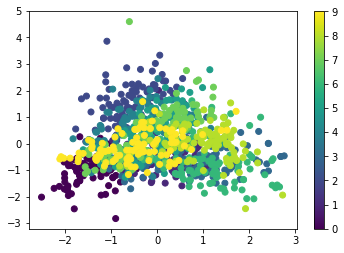

In [7]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=y)
plt.colorbar()
plt.show()

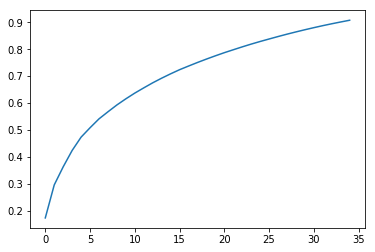

In [8]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [9]:
# Use LDA only for visualization
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y)

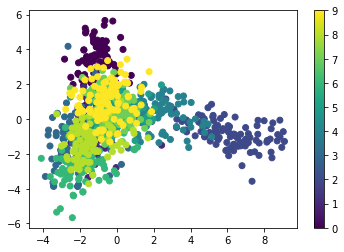

In [10]:
plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.colorbar()
plt.show()

In [11]:
# Using tsne
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.009s...
[t-SNE] Computed neighbors for 1000 samples in 0.307s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.529069
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.439522
[t-SNE] Error after 1000 iterations: 1.229578


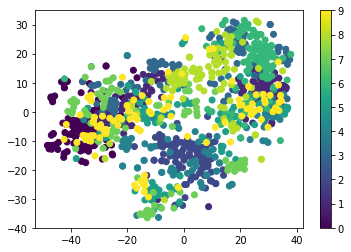

In [12]:
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y)
plt.colorbar()
plt.show()

# Classification

In [13]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [14]:
# K-Fold helper
def kfold_validate(clf, X, y, k_folds = 5):
    # Constants
    acc, count, cm = [], 0, 0
    kf = StratifiedKFold(n_splits=k_folds, shuffle = True, random_state=4321)
    
    # K-fold split
    for train_idx, test_idx in kf.split(X, y):
        # Count each fold are we validating
        count += 1
        
        # Separe training and test in the Training set for k-Fold
        fold_Xtrain, fold_Xtest = X[train_idx], X[test_idx]
        fold_ytrain, fold_ytest = y[train_idx], y[test_idx]
        
        # Normalize the data
        scale = StandardScaler()
        scale.fit(fold_Xtrain)
        fold_Xtrain = scale.transform(fold_Xtrain)
        fold_Xtest = scale.transform(fold_Xtest)

        # Train
        clf = sklearn.base.clone(clf)
        clf.fit(fold_Xtrain, fold_ytrain)
        pred = clf.predict(fold_Xtest)
        accuracy = accuracy_score(fold_ytest, pred)
        cm += confusion_matrix(fold_ytest, pred)
        acc.append(accuracy)
        print("Fold: %s of % s => accuracy_score = %s" %(count, k_folds, accuracy))
    
    print("\n::Accuracy_score statistics::")
    print("Mean = %s%%" % '{0:.5f}'.format(np.mean(acc)))
    print("STD = %s%%" % '{0:.5f}'.format(np.std(acc)))
    return cm

Fold: 1 of 5 => accuracy_score = 0.465
Fold: 2 of 5 => accuracy_score = 0.53
Fold: 3 of 5 => accuracy_score = 0.455
Fold: 4 of 5 => accuracy_score = 0.54
Fold: 5 of 5 => accuracy_score = 0.515

::Accuracy_score statistics::
Mean = 0.50100%
STD = 0.03455%


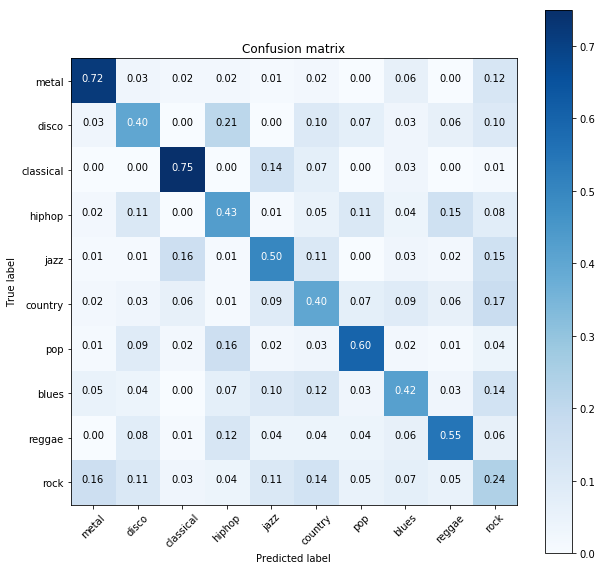

In [15]:
# Decision Tree
cart = DecisionTreeClassifier(criterion = 'entropy')
cm = kfold_validate(cart, X, y)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, genres.keys(), normalize=True)

Fold: 1 of 5 => accuracy_score = 0.695
Fold: 2 of 5 => accuracy_score = 0.715
Fold: 3 of 5 => accuracy_score = 0.69
Fold: 4 of 5 => accuracy_score = 0.715
Fold: 5 of 5 => accuracy_score = 0.685

::Accuracy_score statistics::
Mean = 0.70000%
STD = 0.01265%


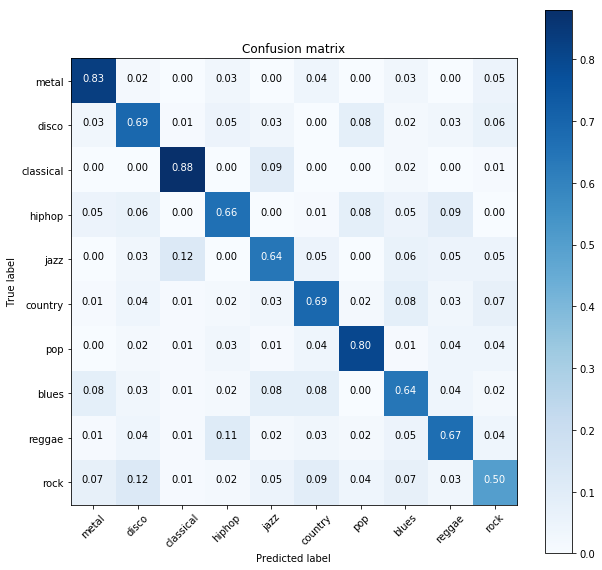

In [16]:
# Logistic Regression
lr = LogisticRegression(penalty='l2', C = 1)
cm = kfold_validate(lr, X, y)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, genres.keys(), normalize=True)

Fold: 1 of 5 => accuracy_score = 0.68
Fold: 2 of 5 => accuracy_score = 0.71
Fold: 3 of 5 => accuracy_score = 0.665
Fold: 4 of 5 => accuracy_score = 0.725
Fold: 5 of 5 => accuracy_score = 0.725

::Accuracy_score statistics::
Mean = 0.70100%
STD = 0.02437%


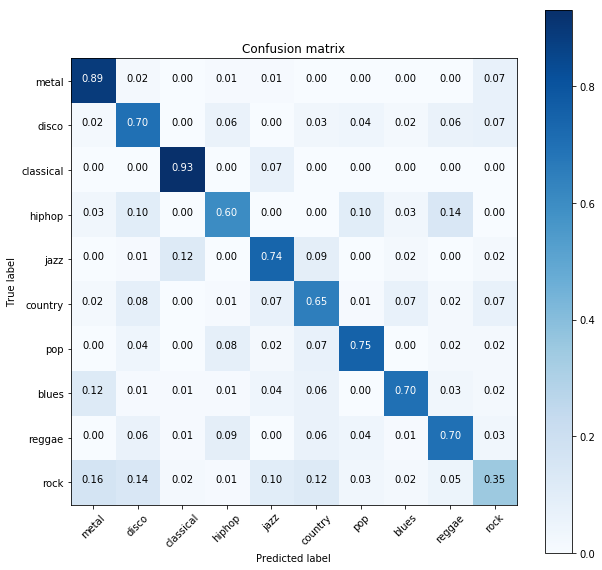

In [17]:
# Random Forests
rf = RandomForestClassifier(n_estimators=150, criterion='gini', max_depth = 15)
cm = kfold_validate(rf, X, y)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, genres.keys(), normalize=True)

Fold: 1 of 5 => accuracy_score = 0.72
Fold: 2 of 5 => accuracy_score = 0.8
Fold: 3 of 5 => accuracy_score = 0.735
Fold: 4 of 5 => accuracy_score = 0.805
Fold: 5 of 5 => accuracy_score = 0.75

::Accuracy_score statistics::
Mean = 0.76200%
STD = 0.03444%


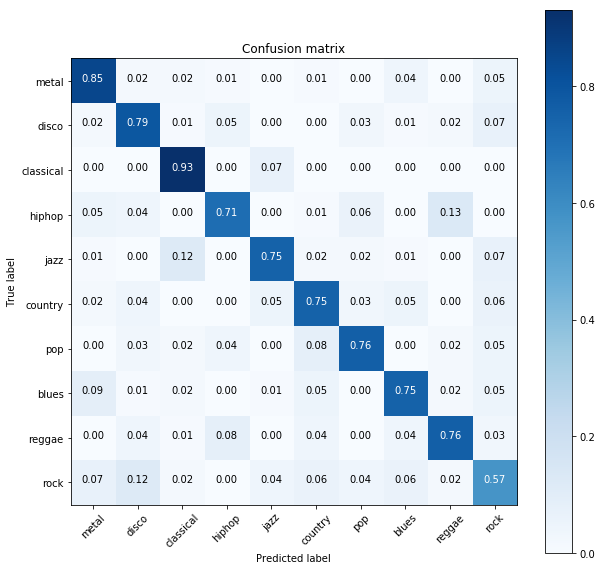

In [18]:
# SVM
# 'linear', 'poly', 'rbf', 'sigmoid'
svm = SVC(C=2, kernel='rbf')
cm = kfold_validate(svm, X, y)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, genres.keys(), normalize=True)